# Separating Mouse and Human Antibody Sequences using Protein Encoding and Machine Learning Classifiers

### Questions:

- How can we train a machine learning classifier to tell apart two groups of protein sequences?

- How can we check for overfitting in a trained machine learning classifier?


### Objectives:
    
- To understand how protein sequences can become readable to machine learning predictors

- To check for overfitted data by testing with a totally naive dataset


### Introduction 

If we want to train a classifier that exploits the differences between two groups of proteins, we need to extract numerical information from their constituent amino acid sequences. This is called encoding and can be done in a number of ways including residue level encoding of each amino acid with a 1x20 vector, representing the possibility of 20 amino acids at each residue. This is called One Hot Encoding, but often leads to a sparse dataset which is not suitable for machine learning tasks as each sequence must be spaced out so they are of equal length. Instead, here we use physiochemical properties that may be calculated from the sequence as numeric information (ElAbd *et al.*, 2020). 



## Introduction to Antibodies
Antibodies are "Y" shaped proteins made up of two heavy and two light chains which can bind to a specific antigen. They have become a successful class of biologic therapeutics in cancers and autoimmune diseases as this binding ability can be used to target a molecule to inhibit or enhance a step in a disease pathway.  The functional antigen-binding domains are the Fv, variable fragments, at each fork of the "Y" shape. These Fv fragments are where the variable domains of a heavy chain, VH, and of the light chain, VL, interact and therefore much study has been dedicated to these domains. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. In the past, this knowledge was rare as it came from studying individual antibodies. However, the advent of B-cell encapsulation and Next Generation Sequencing now allows researchers to sequence a whole repertoire of paired antibodies, and thus, this data has become increasingly abundant (Rajan *et al.*, 2018).
![image info](Antibody_Figure.png "Title")<br>

A) Schematic diagram of an antibody protein
B) Ribbon of antiobdy Fv domains 


We will demonstrate below how antibody sequences look and how the Fv sequence translate to structure.


In [31]:
VH = "EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSAITWNSGHIDYADSVEGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAKVSYLSTASSLDYWGQGTLVTVSS"
VL = "DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQRYNRAPYTFGQGTKVEIK"






Therapeutic antibodies can come from a variety of sources, mostly mice and mice with humanized immune systems generating wholly human antibodies. Generating antibodies which the patient immune system will recognise as human is important to ensure an immune response will not be mounted which could lead to the therapetic being ineffective in a given patient. For this reason, it is necessary to screen antibodies for their similarity to mouse sequences as a way of predicting how likely they are to cause an immune reaction in patients.


In this Lesson, we will use a sample of 1000 human and 1000   mouse paired antibodies obtained from the Observed Antibody Space database (Olsen *et al.*, 2022) and train a machine learning classifier to tell them apart. Firstly, we will use one hot encoding, which is representing each amino acid sequence as an nx20 matrix. Secondly we will use amino acid compositions, composition statistics are feature vectors quantifying the proportion of each amino acid relative to the sequence length for each residue, dipeptides and tripeptides (Sequeira *et al.*, 2022) to generate our encodings from an input of FASTA formatted sequences. Secondly, we will split those encodings into training and test datasets for a selection of machine learning classifiers and compare the results for both methods of encoding.



### References

[ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235.](https://doi.org/10.1186/s12859-020-03546-x) 

[Nakai, K., Kidera, A., & Kanehisa, M. (1988). Cluster analysis of amino acid indices for prediction of protein structure and function. Protein Engineering, Design and Selection, 2(2), 93-100.](https://doi.org/10.1093/protein/2.2.93)

[Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired and paired antibody sequences. Protein Science, 31(1), 141–146.](https://doi.org/https://doi.org/10.1002/pro.4205)

[Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5.](https://doi.org/10.1038/s42003-017-0006-2)

[Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning. Neurocomputing, 484, 172–182.](https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102)

In [32]:
RANDOM_SEED = 42

##Get Encodings###
import sys
from Bio import SeqIO
from Bio import pairwise2
import re
sys.path.append('../src/')
sys.path.append('')
import pandas as pd
from pandas import read_csv
#from propythia.protein.sequence import ReadSequence
#sequence=ReadSequence()
#from propythia.protein import descriptors


##Data preparation###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import zeros, array
from matplotlib.pyplot import subplots
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed


##Machine Learning Models###
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans


##Plotting Results###
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import seaborn as sns



##Model Optimisation###
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


## Studying the Sequences
We will print out the first 10 paired human sequences in our dataset to demonstratet the sequences in the dataset look like.


In [33]:

aa_decimal = {'A': int('00001', 2),
'C': int('00010', 2),
'D': int('00011', 2),
'E': int('00100', 2),
'F': int('00101', 2),
'G': int('00110', 2),
'H': int('00111', 2),
'I': int('01000', 2),
'K': int('01001', 2),
'L': int('01010', 2),
'M': int('01011', 2),
'N': int('01100', 2),
'P': int('01101', 2),
'Q': int('01110', 2),
'R': int('01111', 2),
'S': int('10000', 2),
'T': int('10001', 2),
'V': int('10010', 2),
'W': int('10011', 2),
'Y': int('10100', 2),
'X': int('00000', 2)
}

In [34]:
def Get_First_10_Sequences(fasta):
    VH_sequences = []
    VL_sequences = []
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
        if len(VH_sequences) == 10 and len(VL_sequences) == 10:
            return(VH_sequences, VL_sequences)
   

def pad_lists(list_of_lists, pad_char):
    max_length = max(len(lst) for lst in list_of_lists) 
    padded_lists = []
    for lst in list_of_lists:
        padded_lst = lst + [pad_char] * (max_length - len(lst))
        padded_lists.append(padded_lst)
    return padded_lists

def repeat_list_to_length(lst, length):
    repeated_list = []
    while len(repeated_list) < length:
        repeated_list.extend(lst[:length - len(repeated_list)])
    return repeated_list[:length]

input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'
First_10_Sequences = Get_First_10_Sequences(input_fasta)
First_10_VH_sequences = First_10_Sequences[0]
First_10_VL_sequences = First_10_Sequences[1]
for i in range(len(First_10_VH_sequences)):
    print(First_10_VH_sequences[i],First_10_VL_sequences[i])



    

QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLEWVSYISSSGSSLYYADSVMGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCASGAVTDFVYWGQGALVTVSS QSALTQPPSASGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAPKLMIYEVSKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYAGINNFRVFGGGTKLTVL
QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVANISYDGSNKYYADSVKGRLTISRDNSKNTLYLQMNSLRDEDTSMYYCAKEGPLYSSGYYFDYWGQGTLVTVSS EIVMTQSPATLSVSPGERATLSCRTSQSISSNLAWYQQKPGQAPRLLIYGASTRATGIPPRFSGSGSGTEFTLTISSLQSEDLAVYYCQQYNNLYTFGQGTKLEIK
EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLEWVGRIKSKIDGEAPDYAAPVKGRFLISRDDSNNTLYLQLTSLKTEDTAVYFCTTDRTHYYDSFYWGQGVLVTVSS EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYFAWYQQKPGQAPRLLIYDASTRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGTFFGGGTRVEIK
EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLEWVGRIKSKGGGGTVDYAAPMRGRFTISRDDSINTLYLEMNSLKSEDTGVYYCSHQIDYHYRMDFWGQGTTVTVSS QSALTQPPSASGSPGQSVTISCTGTSGDVGGHNYVTWYQQHPGKAPKLIIYEVTKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYTGTNLVFGGGTKLTVL
QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLEWVAYIRYDGNNKYYAESVKGRFTVSRDNSKNTLY

As we can see, some of the sequences have residues which align throughout all of the 10 sequences we have chosen, but this is difficult visualise by looking at the raw sequences. What could help is to visualise these sequences using a heat map, where each colour represents a different kind of amino acid. In this case, we will just pad out the end of the sequence with a dummy amino acid 'X' so they are all the same length to plot.

Text(0.5, 0, 'Amino Acid Position')

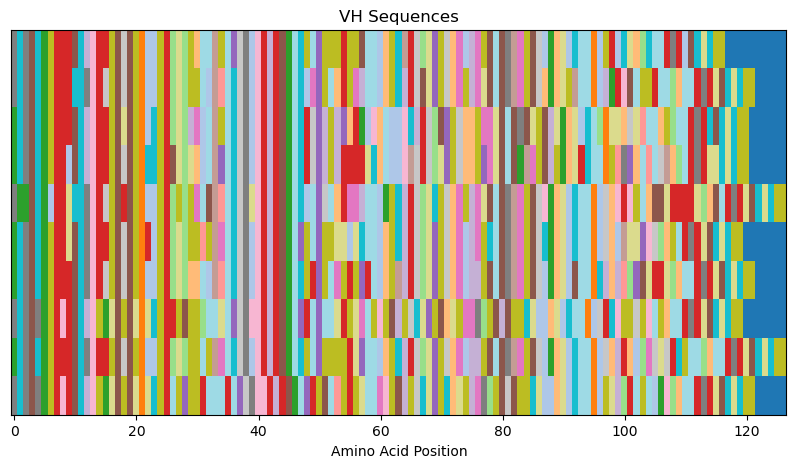

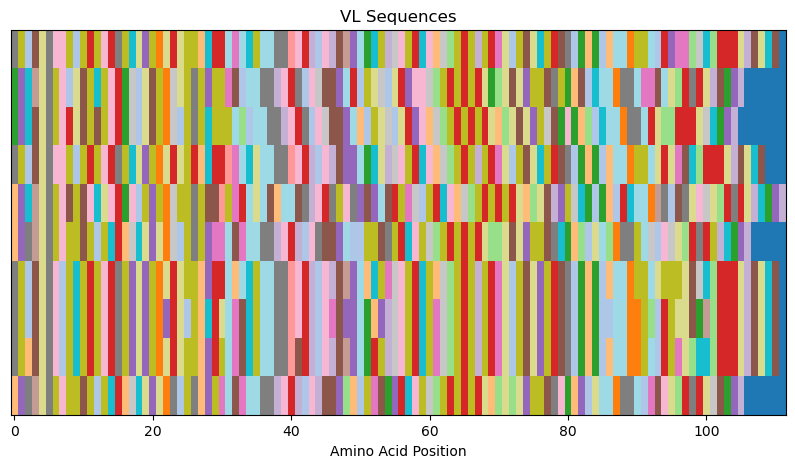

In [35]:
First_10_VH_sequences_decimal = []
for i in range(len(First_10_VH_sequences)):
    current_seq = []
    for aa in First_10_VH_sequences[i]:
        current_seq.append(aa_decimal[aa])
    First_10_VH_sequences_decimal.append(current_seq)
First_10_VL_sequences_decimal = []
for i in range(len(First_10_VL_sequences)):
    current_seq = []
    for aa in First_10_VL_sequences[i]:
        current_seq.append(aa_decimal[aa])
    First_10_VL_sequences_decimal.append(current_seq)

padded_VH_decimal = pad_lists(First_10_VH_sequences_decimal,0)
padded_VL_decimal = pad_lists(First_10_VL_sequences_decimal,0)
        
VH_aa_combined = np.array((padded_VH_decimal[0],padded_VH_decimal[1],padded_VH_decimal[2],padded_VH_decimal[3],padded_VH_decimal[4],padded_VH_decimal[5],padded_VH_decimal[6],padded_VH_decimal[7],padded_VH_decimal[8],padded_VH_decimal[9]))
VL_aa_combined = np.array((padded_VL_decimal[0],padded_VL_decimal[1],padded_VL_decimal[2],padded_VL_decimal[3],padded_VL_decimal[4],padded_VL_decimal[5],padded_VL_decimal[6],padded_VL_decimal[7],padded_VL_decimal[8],padded_VL_decimal[9]))

fig, ax = subplots(figsize=(10, 5))

ax.imshow(VH_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VH Sequences")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position")

fig, ax = subplots(figsize=(10, 5))

ax.imshow(VL_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position")



So from here, it looks like at the start of the sequences, there are points where all of the residues are aligned, but insersions in the sequence have shifted some residues out of alignment with each other. Let's try a sequence alignment using an antibody numbering scheme to try and tidy these up. What we will show is that these numbering schemes will align these sequences by arranging the pad amino acid 'X' throughout the sequences at known points where insersions and deletions occur, so each residue in a numbered sequence is in the same position as it would be on another sequence.

There are a selection of numbering schemes that have been developed for antibodies that have slight variations to where they allow insersions and deletions within the sequence. To find out more about numbering schemes, read more on [Professor Andrew Martin's website](http://www.bioinf.org.uk/abs/info.html). We will use the Chothia numbering scheme as it is seen as the most popular.

In [36]:
import argparse
import sys
import re
import requests

'''
This code has been adapted from other programmes to apply numbering schemes to antibodies. Please do not edit this code. 

'''
class annotate():

    def __init__(self, aaseq, scheme):

        self.aaseq=aaseq
        self.scheme=scheme

    def __repr__(self):
        return "Annotation of VH or VL sequence using Kabat, Chothia, Contact, or IMGT scheme"
    def output(self, chain, lst, regionlst):
        """
        Prints the FR and CDR regions and their corresponding seq. It returns a `list` of 2 `dict`.
        :param chain: STRING, either "H" or "L" in uppercase
        :param lst:  LIST, a list of residue and their corresponding numbers in kabat or chothia scheme
        :param regionlst: LIST, a list of peptides, each corresponds to a FR or CDR region
        :return: LIST, a list of 2 `dict`, The first dict consists of region: seq pairs. The second dict consists of number:residue pairs.
        """
        self.chain=chain
        self.lst=lst
        self.regionlst=regionlst

        self.regiondict, self.numberdict={}, {}

        for i in range (0, len(self.lst), 2):
            self.numberdict[self.lst[i]]=self.lst[i+1]


        if self.chain=="L":
            Region_list = [self.regionlst[0],self.regionlst[1],self.regionlst[2],self.regionlst[3],self.regionlst[4],self.regionlst[5],self.regionlst[6]]
            #print(Region_list)

            for region, seq in zip(["L-FR1", "L-CDR1", "L-FR2","L-CDR2", "L-FR3", "L-CDR3", "L-FR4"], self.regionlst):
                self.regiondict[region]=seq

            return [self.regionlst, self.numberdict]

        else:
            Region_list = [self.regionlst[0],self.regionlst[1],self.regionlst[2],self.regionlst[3],self.regionlst[4],self.regionlst[5],self.regionlst[6]]
            #print(Region_list)

            for region, seq in zip(["H-FR1", "H-CDR1", "H-FR2","H-CDR2", "H-FR3", "H-CDR3", "H-FR4"], self.regionlst):
                self.regiondict[region]=seq
            return [self.regionlst, self.numberdict]


    def analyze(self,chain, lst):
        """
        Define CDR and FR regions based on the numbered sequence returned from website
        :param chain: STRING, "H" or "L" in uppercase
        :param lst: LIST, a list of residue and their corresponding numbers in kabat or chothia scheme
        :return: LIST, a list of strings, where each string is a peptide corresponding to the a region, in the order of: FR1, CDR1, FR2, CDR2, FR3, CDR3, FR4
        :raises: `ValueError` if any of the FR or CDR region is missing
        """

        self.chain=chain
        self.lst=lst
        if self.chain=="L":
            self.L_FR1, self.L_CDR1, self.L_FR2, self.L_CDR2, self.L_FR3, self.L_CDR3, self.L_FR4=["" for i in range (0, 7)]

            try:
                if self.scheme in ["kabat", "chothia"]:
                    self.L_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("L24"), 2)])
                    self.L_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("L24"), self.lst.index("L35"), 2)])
                    self.L_FR2="".join([self.lst[i+1] for i in range (self.lst.index("L35"), self.lst.index("L50"), 2)])
                    self.L_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("L50"), self.lst.index("L57"), 2)])
                    self.L_FR3="".join([self.lst[i+1] for i in range (self.lst.index("L57"), self.lst.index("L89"), 2)])
                    self.L_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("L89"), self.lst.index("L98"), 2)])
                    self.L_FR4="".join([self.lst[i+1] for i in range (self.lst.index("L98"), len(self.lst), 2)])

                return [self.L_FR1, self.L_CDR1, self.L_FR2, self.L_CDR2, self.L_FR3, self.L_CDR3, self.L_FR4]

            except ValueError:
                print("Unable to retrieve complete V region. Make sure the sequence has complete V region")
            except:
                print("An error occured")
        else:
            self.H_FR1, self.H_CDR1, self.H_FR2, self.H_CDR2, self.H_FR3, self.H_CDR3, self.H_FR4=["" for i in range (0, 7)]

            try:

                if self.scheme=="chothia":
                    self.H_FR1="".join([self.lst[i+1] for i in range (0, self.lst.index("H26"), 2)])
                    self.H_CDR1="".join([self.lst[i+1] for i in range (self.lst.index("H26"), self.lst.index("H33"), 2)])
                    self.H_FR2="".join([self.lst[i+1] for i in range (self.lst.index("H33"), self.lst.index("H52"), 2)])
                    self.H_CDR2="".join([self.lst[i+1] for i in range (self.lst.index("H52"), self.lst.index("H57"), 2)])
                    self.H_FR3="".join([self.lst[i+1] for i in range (self.lst.index("H57"), self.lst.index("H95"), 2)])
                    self.H_CDR3="".join([self.lst[i+1] for i in range (self.lst.index("H95"), self.lst.index("H103"), 2)])
                    self.H_FR4="".join([self.lst[i+1] for i in range (self.lst.index("H103"), len(self.lst), 2)])


                return [self.H_FR1, self.H_CDR1, self.H_FR2, self.H_CDR2, self.H_FR3, self.H_CDR3, self.H_FR4]

            except ValueError:
                print("Unable to retrieve complete V region. Make sure the sequence has complete V region")
            except:
                print("An error occured in the `analyze()` method")

    def retrieve (self):

        self.url="http://www.bioinf.org.uk/abs/abnum/abnum.cgi"

        try:
            if self.scheme not in ["kabat", "chothia", "contact", "imgt", "martin"]:
                raise Exception

        except ValueError:
            print("Incorrect scheme mode. Must be one of the following (lowercase): kabat, chothia, contact, imgt")

        else:
            if self.scheme=="kabat":
                self.sche="-k"
            elif self.scheme=="chothia":
                self.sche="-c"
            elif self.scheme=="martin":
                self.sche="-m"

        try:
            self.d={"plain":1, "scheme":self.sche, "aaseq":self.aaseq}
            self.myPage=requests.get(self.url, params=self.d)
            self.text=self.myPage.text
            self.lst=self.text.split()

            if len(self.lst)>1:
                self.chain=self.lst[0][0]
                self.result=self.output(self.chain, self.lst, self.analyze(self.chain, self.lst))
                return self.result
            else:
                print("No annotation retrieved. Did you enter the complete VH or VL sequence?")
        except:
            print("An error occured in the `retrieve()` method")

def get_spaced_sequence(Heavy_seq, Light_seq, scheme):
    try:
        seq1=annotate(Heavy_seq,scheme)
        heavy_sequence_split = seq1.retrieve()[0]
        heavy_sequence_num   = seq1.retrieve()[1]
        heavy_sequence_num_list = list(heavy_sequence_num.keys())
        seq2=annotate(Light_seq,scheme)
        light_sequence_split = seq2.retrieve()[0]
        light_sequence_num   = seq2.retrieve()[1]
        light_sequence_num_list = list(light_sequence_num.keys())


        if scheme == 'kabat':
            Heavy_sorter = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24','H25','H26','H27','H28','H29','H30','H31','H32','H33','H34','H35','H35A','H35B','H36','H37','H38','H39','H40','H41','H42','H43','H44','H45','H46','H47','H48','H49','H50','H51','H52','H52A','H52B','H52C','H53','H54','H55','H56','H57','H58','H59','H60','H61','H62','H63','H64','H65','H66','H67','H68','H69','H70','H71','H72','H73','H74','H75','H76','H77','H78','H79','H80','H81','H82','H82A','H82B','H82C','H83','H84','H85','H86','H87','H88','H89','H90','H91','H92','H93','H94','H95','H96','H97','H98','H99','H100','H100A','H100B','H100C','H100D','H100E','H100F','H100G','H100H','H100I','H100J','H100K','H101','H102','H103','H104','H105','H106','H107','H108','H109','H110','H111','H112','H113']
            Light_sorter = ['L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14','L15','L16','L17','L18','L19','L20','L21','L22','L23','L24','L25','L26','L27','L27A','L27B','L27C','L27D','L27E','L27F','L28','L29','L30','L31','L32','L33','L34','L35','L36','L37','L38','L39','L40','L41','L42','L43','L44','L45','L46','L47','L48','L49','L50','L51','L52','L53','L54','L55','L56','L57','L58','L59','L60','L61','L62','L63','L64','L65','L66','L67','L68','L69','L70','L71''L72','L73','L74','L75','L76','L77','L78','L79','L80','L81','L82','L83','L84','L85','L86','L87','L88','L89','L90','L91','L92','L93','L94','L95','L95A','L95B','L95C','L95D','L95E','L95F','L96','L97','L98','L99','L100','L101','L102','L103','L104','L105','L106','L106A','L107','L108','L109']
        elif scheme == 'chothia':
            Heavy_sorter = ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24','H25','H26','H27','H28','H29','H30','H31','H31A','H31B','H32','H33','H34','H35','H36','H37','H38','H39','H40','H41','H42','H43','H44','H45','H46','H47','H48','H49','H50','H51','H52','H52A','H52B','H52C','H53','H54','H55','H56','H57','H58','H59','H60','H61','H62','H63','H64','H65','H66','H67','H68','H69','H70','H71','H72','H73','H74','H75','H76','H77','H78','H79','H80','H81','H82','H82A','H82B','H82C','H83','H84','H85','H86','H87','H88','H89','H90','H91','H92','H93','H94','H95','H96','H97','H98','H99','H100','H100A','H100B','H100C','H100D','H100E','H100F','H100G','H100H','H100I','H100J','H100K','H101','H102','H103','H104','H105','H106','H107','H108','H109','H110','H111','H112','H113']
            Light_sorter = ['L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14','L15','L16','L17','L18','L19','L20','L21','L22','L23','L24','L25','L26','L27','L28','L29','L30','L30A','L30B','L30C','L30D','L30E','L30F','L31','L32','L33','L34','L35','L36','L37','L38','L39','L40','L41','L42','L43','L44','L45','L46','L47','L48','L49','L50','L51','L52','L53','L54','L55','L56','L57','L58','L59','L60','L61','L62','L63','L64','L65','L66','L67','L68','L69','L70','L71','L72','L73','L74','L75','L76','L77','L78','L79','L80','L81','L82','L83','L84','L85','L86','L87','L88','L89','L90','L91','L92','L93','L94','L95','L95A','L95B','L95C','L95D','L95E','L95F','L96','L97','L98','L99','L100','L101','L102','L103','L104','L105','L106','L106A','L107','L108','L109']
        else:
            print("no scheme provided")
            quit()
        spaced_heavy_seq = ""
        for x in range(len(Heavy_sorter)):
            if Heavy_sorter[x] not in heavy_sequence_num_list:
                spaced_heavy_seq += "X"
            elif Heavy_sorter[x] in heavy_sequence_num_list:
                spaced_heavy_seq += str(heavy_sequence_num.get(Heavy_sorter[x]))

            #reordered_Heavy_dict = {x: Heavy_chain_ptm_counts[x] for x in Heavy_sorter}

        spaced_light_seq = ""
        for x in range(len(Light_sorter)):
            if Light_sorter[x] not in light_sequence_num:
                spaced_light_seq += "X"
            elif Light_sorter[x] in light_sequence_num_list:
                spaced_light_seq += str(light_sequence_num.get(Light_sorter[x]))
        return(spaced_heavy_seq,spaced_light_seq)
    except:
        pass

Spaced_VH_seqs = []
Spaced_VL_seqs = []
for i in range(len(First_10_VH_sequences)):
    spaced_sequences = get_spaced_sequence(str(First_10_VH_sequences[i]),str(First_10_VL_sequences[i]), "chothia")
    Spaced_VH_seqs.append(spaced_sequences[0])
    Spaced_VL_seqs.append(spaced_sequences[1])
    

Text(0.5, 0, 'Amino Acid Position (Chothia Numbering Scheme)')

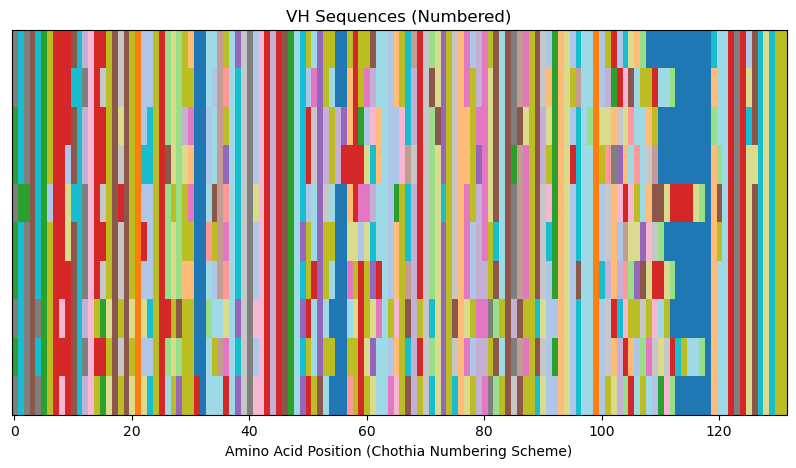

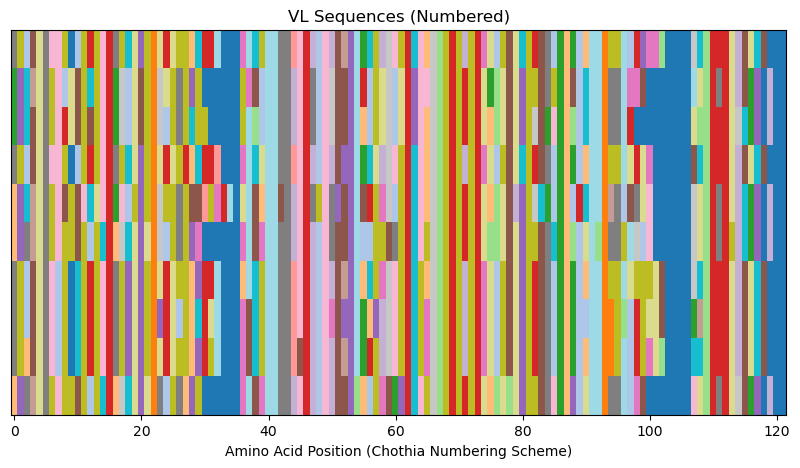

In [37]:
Spaced_VH_seqs_decimal = []
for i in range(len(Spaced_VH_seqs)):
    current_seq = []
    for aa in Spaced_VH_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Spaced_VH_seqs_decimal.append(current_seq)
    
Spaced_VL_seqs_decimal = []
for i in range(len(Spaced_VL_seqs)):
    current_seq = []
    for aa in Spaced_VL_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Spaced_VL_seqs_decimal.append(current_seq)
   
VH_aa_combined = np.array((Spaced_VH_seqs_decimal[0],Spaced_VH_seqs_decimal[1],Spaced_VH_seqs_decimal[2],Spaced_VH_seqs_decimal[3],Spaced_VH_seqs_decimal[4],Spaced_VH_seqs_decimal[5],Spaced_VH_seqs_decimal[6],Spaced_VH_seqs_decimal[7],Spaced_VH_seqs_decimal[8],Spaced_VH_seqs_decimal[9]))
VL_aa_combined = np.array((Spaced_VL_seqs_decimal[0],Spaced_VL_seqs_decimal[1],Spaced_VL_seqs_decimal[2],Spaced_VL_seqs_decimal[3],Spaced_VL_seqs_decimal[4],Spaced_VL_seqs_decimal[5],Spaced_VL_seqs_decimal[6],Spaced_VL_seqs_decimal[7],Spaced_VL_seqs_decimal[8],Spaced_VL_seqs_decimal[9]))

fig, ax = subplots(figsize=(10, 5))

ax.imshow(VH_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VH Sequences (Numbered)")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")

fig, ax = subplots(figsize=(10, 5))

ax.imshow(VL_aa_combined, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences (Numbered)")
ax.yaxis.set_visible(False) 
ax.set_ylabel = "Sequence"
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")



This looks much better! Now there are aligned residues throughout the sequences. So in conclusion, this section has demonstrated the points of diversity within VH and VL antibody sequences and how numbering schemes help to align siquences better than traditional sequence alignments or padding out sequences. Using the human sequences we have studied here and 10 representative mouse sequences, we will plot these sequences side by side and try to observe visual differences which represent differences in their sequences.

In [38]:
input_fasta_mouse = './Mouse_1000_paired_sequences.faa.txt'
First_10_Mouse_Sequences = Get_First_10_Sequences(input_fasta_mouse)
First_10_Mouse_Sequences_VH = First_10_Mouse_Sequences[0]
First_10_Mouse_Sequences_VL = First_10_Mouse_Sequences[1]
Mouse_Spaced_VH_seqs = []
Mouse_Spaced_VL_seqs = []
for i in range(len(First_10_Mouse_Sequences_VH)):
    spaced_sequences = get_spaced_sequence(str(First_10_Mouse_Sequences_VH[i]), str(First_10_Mouse_Sequences_VL[i]), "chothia")
    Mouse_Spaced_VH_seqs.append(str(spaced_sequences[0]))
    Mouse_Spaced_VL_seqs.append(str(spaced_sequences[1]))
    
Mouse_Spaced_VH_seqs_decimal = []
for i in range(len(Mouse_Spaced_VH_seqs)):
    current_seq = []
    for aa in Spaced_VH_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Mouse_Spaced_VH_seqs_decimal.append(current_seq)
    
Mouse_Spaced_VL_seqs_decimal = []
for i in range(len(Mouse_Spaced_VL_seqs)):
    current_seq = []
    for aa in Spaced_VL_seqs[i]:
        current_seq.append(aa_decimal[aa])
    Mouse_Spaced_VL_seqs_decimal.append(current_seq)



Text(0.5, 0, 'Amino Acid Position (Chothia Numbering Scheme)')

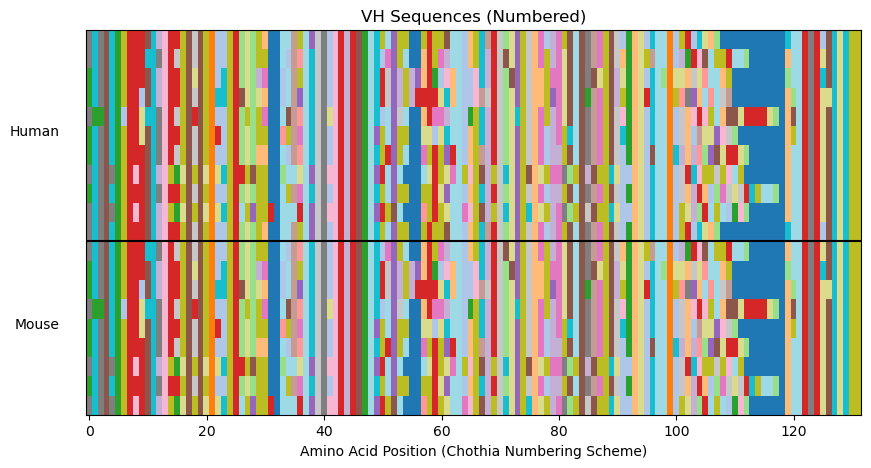

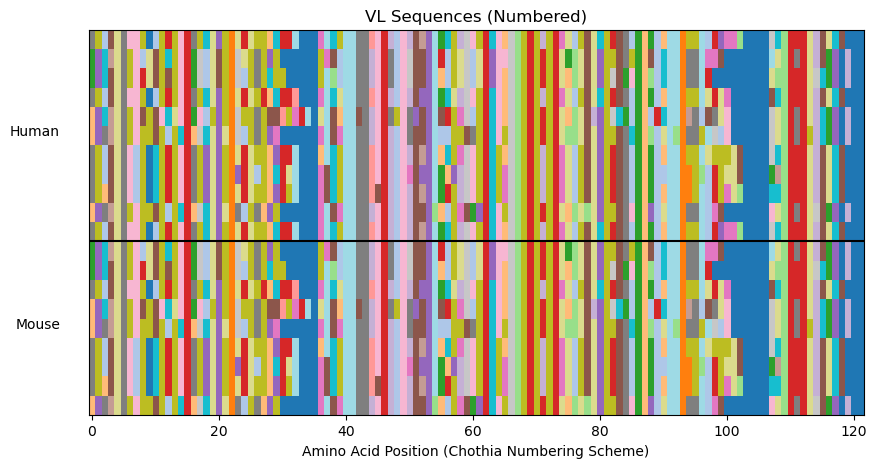

In [39]:

   
VH_aa_combined_human_mouse = np.array((Spaced_VH_seqs_decimal[0],Spaced_VH_seqs_decimal[1],Spaced_VH_seqs_decimal[2],Spaced_VH_seqs_decimal[3],Spaced_VH_seqs_decimal[4],Spaced_VH_seqs_decimal[5],Spaced_VH_seqs_decimal[6],Spaced_VH_seqs_decimal[7],Spaced_VH_seqs_decimal[8],Spaced_VH_seqs_decimal[9],Mouse_Spaced_VH_seqs_decimal[0],Mouse_Spaced_VH_seqs_decimal[1],Mouse_Spaced_VH_seqs_decimal[2],Mouse_Spaced_VH_seqs_decimal[3],Mouse_Spaced_VH_seqs_decimal[4],Mouse_Spaced_VH_seqs_decimal[5],Mouse_Spaced_VH_seqs_decimal[6],Mouse_Spaced_VH_seqs_decimal[7],Mouse_Spaced_VH_seqs_decimal[8],Mouse_Spaced_VH_seqs_decimal[9]))
VL_aa_combined_human_mouse = np.array((Spaced_VL_seqs_decimal[0],Spaced_VL_seqs_decimal[1],Spaced_VL_seqs_decimal[2],Spaced_VL_seqs_decimal[3],Spaced_VL_seqs_decimal[4],Spaced_VL_seqs_decimal[5],Spaced_VL_seqs_decimal[6],Spaced_VL_seqs_decimal[7],Spaced_VL_seqs_decimal[8],Spaced_VL_seqs_decimal[9],Mouse_Spaced_VL_seqs_decimal[0],Mouse_Spaced_VL_seqs_decimal[1],Mouse_Spaced_VL_seqs_decimal[2],Mouse_Spaced_VL_seqs_decimal[3],Mouse_Spaced_VL_seqs_decimal[4],Mouse_Spaced_VL_seqs_decimal[5],Mouse_Spaced_VL_seqs_decimal[6],Mouse_Spaced_VL_seqs_decimal[7],Mouse_Spaced_VL_seqs_decimal[8],Mouse_Spaced_VL_seqs_decimal[9]))

fig, ax = subplots(figsize=(10, 5))
ax.imshow(VH_aa_combined_human_mouse, aspect='auto', cmap='tab20')
ax.axhline(y=10.5, color='black', linestyle='-', label='Horizontal Line at y=6')
ax.text(-5, 5, f'Human', color='black', ha='right')
ax.text(-5, 15, f'Mouse', color='black', ha='right')
ax.yaxis.set_visible(False) 
ax.set_title("VH Sequences (Numbered)")
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")

fig, ax = subplots(figsize=(10, 5))

ax.imshow(VL_aa_combined_human_mouse, aspect='auto', cmap='tab20')
ax.set_title("VL Sequences (Numbered)")
ax.axhline(y=10.5, color='black', linestyle='-', label='Horizontal Line at y=6')
ax.text(-5, 5, f'Human', color='black', ha='right')
ax.text(-5, 15, f'Mouse', color='black', ha='right')
ax.yaxis.set_visible(False) 
ax.set_xlabel("Amino Acid Position (Chothia Numbering Scheme)")


So from this experiment, we can conclude that there are many similarities between human and mouse sequences that mean it is difficult to tell then apart by eye. However, we can use the basis for what we have learned so far and apply these to use machine learning to separate mouse and human sequences using sequence encoding.

## Generating the Encoded Sequences

Here we input our fasta sequences and split the entries into VH and VL sequences. We will then run each set of sequences into the One Hot Encoding. The Encodings for each kind of residue has been saved in the OneHotEncoding dictionary. There are 4000 records in the fasta file representing 2000 paired antibodies. 1000 of these are human and 1000 are mouse.

In [40]:
def Get_OHE_Encoded_Sequences(fasta):
    VH_sequences = []
    VL_sequences = []
    OneHotEncoding = {"A": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "C": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "D": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "E": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "F": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "G": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "H": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "I": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "K": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "L": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "M": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "N": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], "P": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], "Q": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], "R": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], "S": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "T": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], "V": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], "W": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], "Y": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "X": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
            
   
    if len(VH_sequences) == len(VL_sequences):
        VH_encodings = []
        VL_encodings = []
        for i in range(len(VH_sequences)):
            VH_OHE = []
            for res in VH_sequences[i]:
                VH_OHE = VH_OHE + OneHotEncoding[res]
            VH_encodings.append(VH_OHE)
        for i in range(len(VL_sequences)):
            VL_OHE = []
            for res in VL_sequences[i]:
                VL_OHE = VL_OHE + OneHotEncoding[res]
            VL_encodings.append(VL_OHE)
    VH_dataframe = pd.DataFrame(VH_encodings)
    VL_dataframe = pd.DataFrame(VL_encodings)
    VH_labels = []
    VH_labels_list = repeat_list_to_length(list(OneHotEncoding.keys()),VH_dataframe.shape[1])
    for i in range(len(VH_labels_list)):
        position = round((i+1)/21)
        VH_labels.append("VH_position_"+str(position)+"_residue"+str(VH_labels_list[i]))
    VL_labels = []
    VL_labels_list = repeat_list_to_length(list(OneHotEncoding.keys()),VL_dataframe.shape[1])
    for i in range(len(VL_labels_list)):
        position = round((i+1)/21)
        VL_labels.append("VL_position_"+str(position)+"_residue"+str(VL_labels_list[i]))
   
            
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe.columns = VH_labels
    VL_dataframe.columns = VL_labels
    joined_dataframe_VH_VL =  VH_dataframe.join(VL_dataframe)
    joined_dataframe_VH_VL_cleaned = joined_dataframe_VH_VL.dropna(axis=1)
    joined_dataframe_VH_VL_cleaned.to_csv('Human_Mouse_VH_VL_OHE.csv')
    return(joined_dataframe_VH_VL_cleaned)


In [41]:
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'


In [42]:

joined_dataframe_VH_VL = Get_OHE_Encoded_Sequences(input_fasta)
#print(joined_dataframe_VH_VL)

Now we have our encodings and we need to prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing only these:

In [43]:
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2

y=labels
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(len(y) == dataset.shape[0]) ## Check whether number of labels and number of samples are thbe same


True


Now that we have our datasets, we may split them into training datasets for fitting and testing datasets to verify their effectiveness as predictors. A 70/30 or 80/20 split can be used.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

num_rows, num_cols = dataset.shape

print("Training set: ", X_train.shape, "       Test set: ", X_test.shape)


Training set:  (1400, 3738)        Test set:  (600, 3738)


## Separating our data with Machine Learning Classifiers

Next we can import the classifiers that we will be used for testing:


In [45]:
n=2

classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}

To train and test these classifiers, we can loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. We have chosen the Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by as it accounts for both true and false predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood (random labelling). 

We then plot the result as a confusion matrix, demonstrating the predictive power of our classifiers. The Confusion matrix shows the raw number of records that have been assigned to each category in a 2x2 matrix and is given as such: 

|                  | Predicted Class = 0  | Predicted Class = 1 |
|------------------|----------------------|---------------------|
| Actual Class = 0 | True Negative        | False Positive      |
| Actual Class = 1 | False Negative       | True Positive       |

Ideally we want the True Negative and True Positive field to be the most popular fields with none or few records in the False Positive and False Negative fields.

Note that results may vary between each run due to the stochastic nature of the machine learning algorithms.

To evaluate the performance of classifiers, we will use the raw accuracy of the prediction (i.e. what percentage of predictions are correct), and Mattews Correlation Coefficient (MCC) which is a more reliable measure of how well the classifier predicts true positive and true negative results.

$MCC = \frac{(TP * TN - FP * FN)}{ \sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}$


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


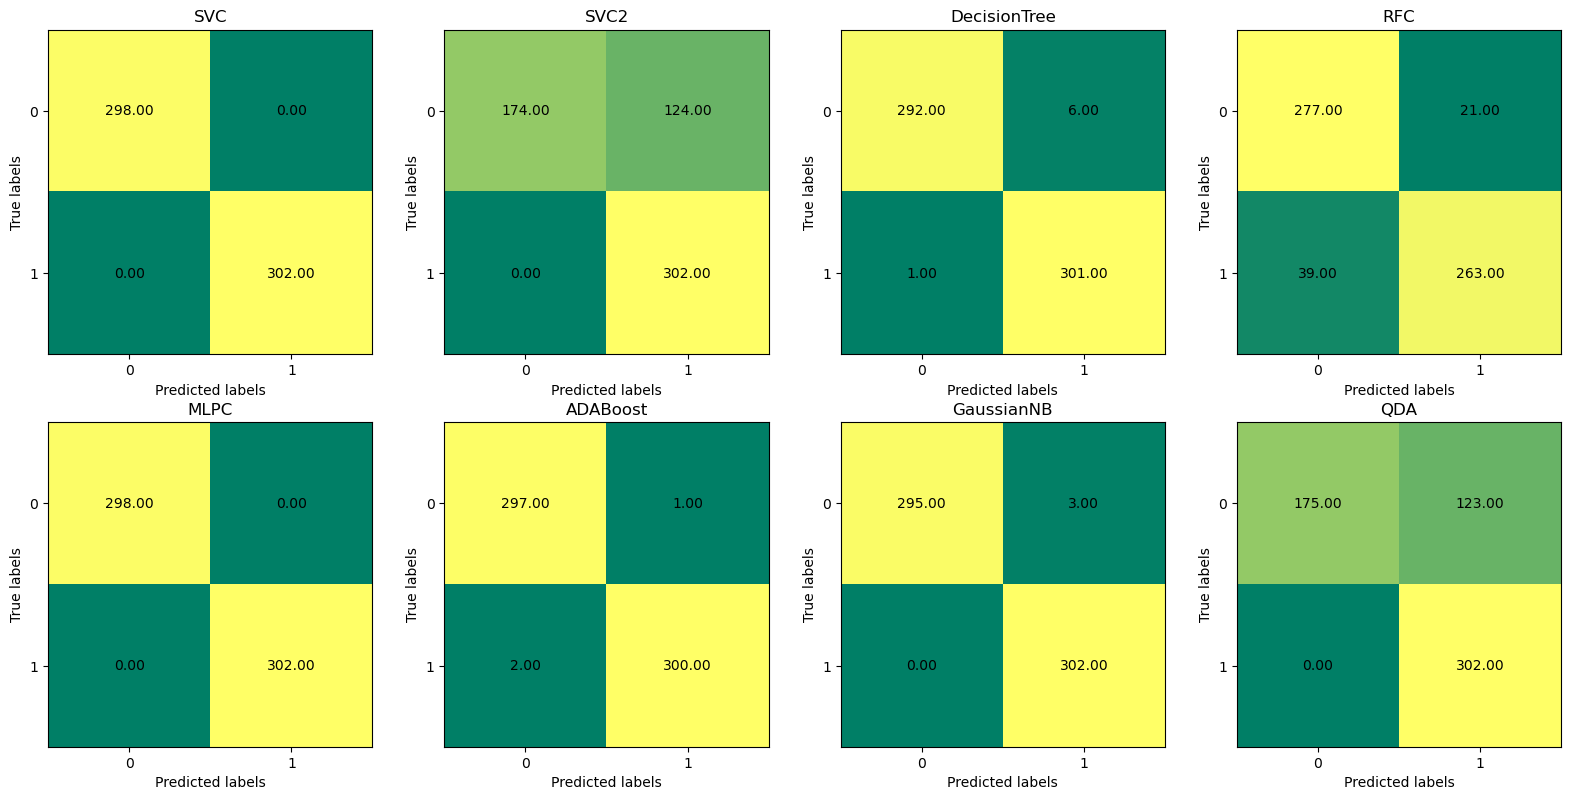

Complete


In [46]:
##Loop through each classifier, fit training data and evaluate model. Plot results as confusion matrix##
class_labels = ["0","1"]
no_classifiers = len(classifiers)

OHE_scores = []

confusion_matrices = []


import seaborn as sns
for i in range(len(list(classifiers.keys()))):
    clf        = classifiers.get(list(classifiers.keys())[i])
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    scoring_acc = accuracy_score(y_test, y_predict)
    scoring    = matthews_corrcoef(y_test, y_predict)
    scores.append(scoring) 
    cf_matrix = metrics.confusion_matrix(y_test, y_predict)
    confusion_matrices.append(cf_matrix)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot confusion matrices
for i, ax in enumerate(axes.flat):
    ax.imshow(confusion_matrices[i], cmap='summer')
    ax.set_title(list(classifiers.keys())[i])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.grid(False)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    # Rotate x-axis labels for better readability

        # Annotate numerical values
    for j in range(confusion_matrices[i].shape[0]):
        for k in range(confusion_matrices[i].shape[1]):
            ax.text(k, j, f'{confusion_matrices[i][j, k]:.2f}', ha='center', va='center', color='black')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
print('Complete')

[1.   0.64 0.98 0.8  1.   0.99 0.99 0.65]


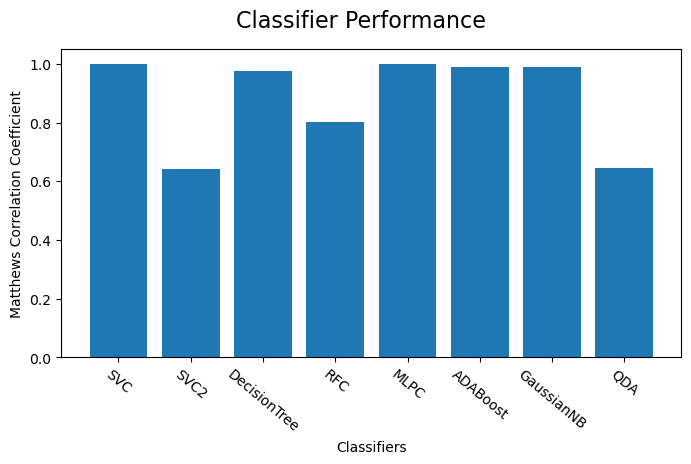

In [47]:
##Plot Performance of all Models##
fig, ax = plt.subplots(figsize=(8, 4))
plt.suptitle('Classifier Performance', fontsize=16)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers', fontsize=10)
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-40);

print(np.around(scores, 2))

As we can see, the majority of these classifiers have successfully learned to classify the two groups of protein structure, with nearly perfect performance in the SVC model, the neural network MLPC, and ADABoost. It is evident that there are highly correlated features in the training data which the models have exploited. However, the Kidera factor is not the only method of encoding sequences for machine learning algorithms. In fact, for more complex problems, deeper methods of encoding may be required.

### Using Amino Acid Compositions to Encode Protein Sequences

Amino acid compositions are a sequence based statistic as compared to the basic level of encoding as seen in the One Hot Encoding. The latter generate much denser and complex encodings which we will compare with the Kidera factor method. 


In [48]:
###Propythia Command to get encodings###
def get_descriptors(protein):
    ##This will retrieve a selection of encodings that are not dependent on the sequence length##
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [49]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
   
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VH_dataframe.loc[len(VH_dataframe)] = descriptors
            VH_dataframe = VH_dataframe._append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VL_dataframe.loc[len(VL_dataframe)] = descriptors
            VL_dataframe = VL_dataframe._append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


In [50]:
### Input Fasta and Run Dataset###
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'

#joined_dataframe_VH_VL = Get_dataset(input_fasta)

###Optionally save dataframe as a CSV to simply reload it in future###
#joined_dataframe_VH_VL.to_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors')#
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)

### Do it yourself
- The Propythia encodings were selected to reduce the time taken to run. Retry the encoding step and experiment with the protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]) array.

- Note that Propythia accepts numbers from 0-40 however we avoid 1, 2 and 37 as these produce outputs of differing length

In [51]:
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0##

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 890)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


### Do it yourself
- The list of classifiers used above is not exhaustive. These were picked to represent the major classes of models. You will find a much larger list of classifiers supported in scikit-learn here: https://scikit-learn.org/stable/supervised_learning.html.

- Try adding some new classifiers to the classifier dictionary and check how the results differ.


In [53]:

#classifiers = {
#   'KNeighbours': KNeighborsClassifier(2),
#   'Gaussian':    GaussianMixture(n_components=n),
#   'KMeans':      KMeans(n_clusters=n)
#}
n=2

classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}

In [54]:
AAC_scores = []
for i in range(len(list(classifiers.keys()))):
    clf        = classifiers.get(list(classifiers.keys())[i])
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    scoring_acc = accuracy_score(y_test, y_predict)
    scoring    = matthews_corrcoef(y_test, y_predict)
    AAC_scores.append(scoring) 



/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


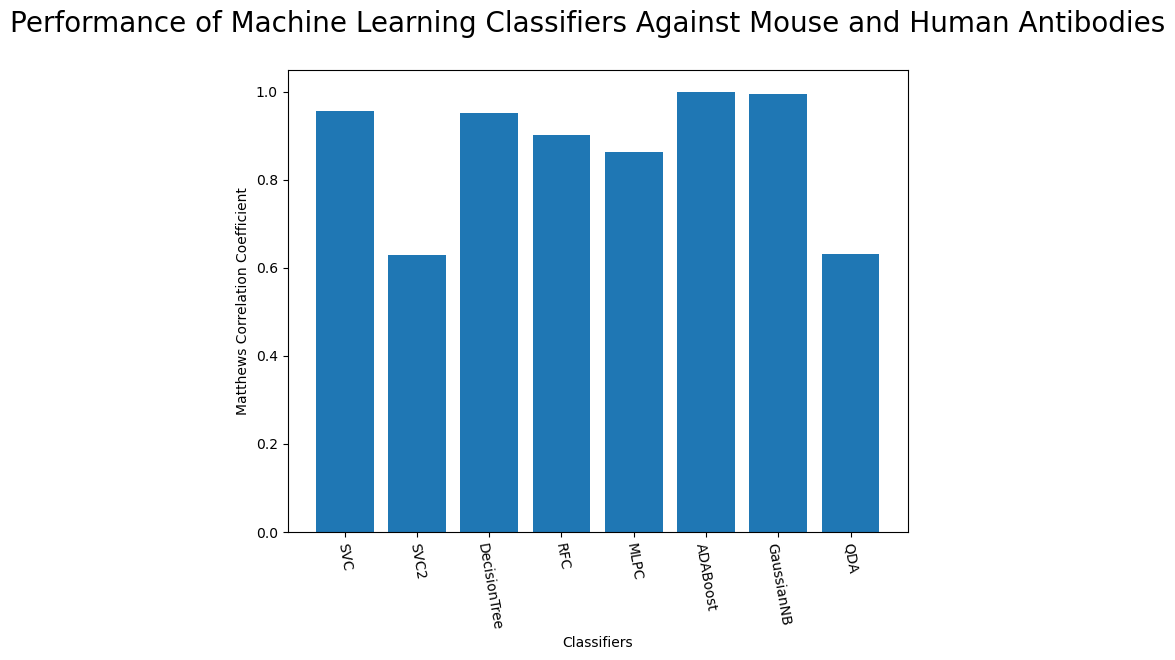

In [55]:
##Plot Performance of all Models##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(AAC_scores)), AAC_scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

The above chart indicates that the best performing predictors are ADABoost, GaussianNB, DecisionTree and SVC are the best performing classifiers, wheras KMeans is the worst performing with negative MCC scores.




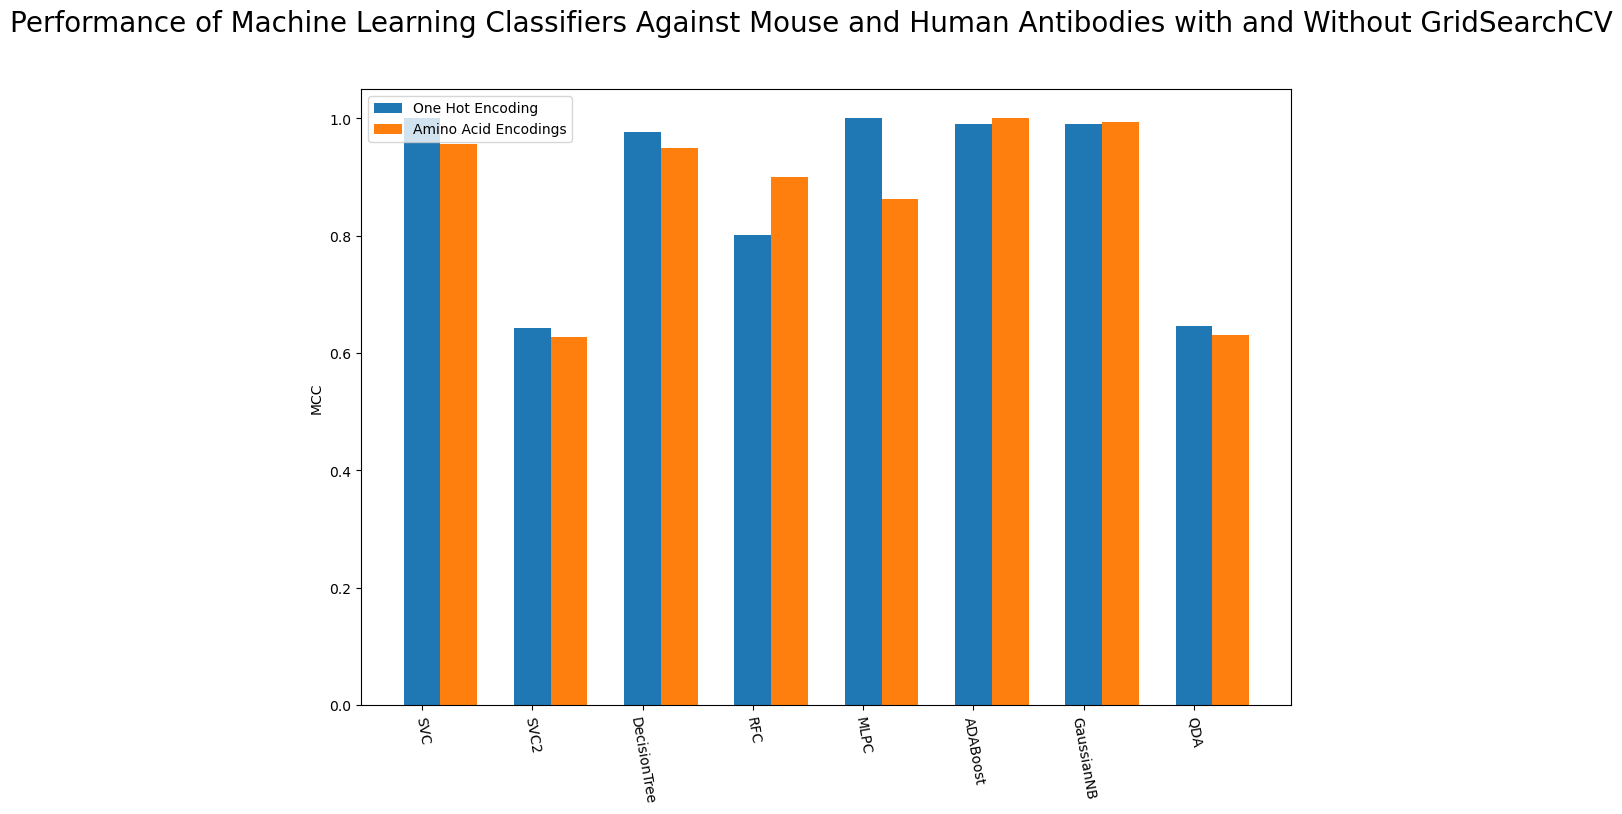

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
aranged = np.arange(len(classifiers.keys())) 
width = 1/3

bar1 = plt.bar(aranged, OHE_scores, width,label = 'One Hot Encoding')
bar2 = plt.bar(aranged+width,  AAC_scores, width,label = 'Amino Acid Encodings')

plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);


plt.legend()
plt.show()

From this plot, it can be concluded that overall the performance of the machine learning classifiers predicting if an antibody is closer to human or mouse is similar between the One Hot Encoding encoded antibodies and the antibodies encoded with amino acid compositions. This is especially the case for the SVC, ADABoost and GaussianNB classifiers, which achieve very high performance. This probably means there are very obvious sequence differences between mouse and human antibodies which can be encoded with very basic methods, but which are also too subtle to be observed using inspection. 

### Questions
- Which encoding method produced the best results overall? Why could this be? Hint: think of the size of both sets of encodings
- What could be the advantages and disadvantages of both sets of encodings?


## End of Chapter Exercise: Testing our Classifiers on a Naïve Dataset

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings.

We can also take a totally naïve dataset that the model has not been exposed to. This is a measure that checks for overfitting. If we see that there is poor performance on this naïve "held back" dataset, then it could suggest overfitting to the training data. Using 20 Human and 20 mouse paired sequences from OAS, which were not used to train our models, it is possible to generate their encodings, and pass them through the optimised model, in order to test it.  

The file below has 20 human and 20 mouse sequences which are held back from our original training data. Using the skills you have learned so far in this notebook, encode these paired sequences and generate a list of labels for these entries. Pass them through the trained classifiers and evaluate their performance.

- Comment on which classifier performs best.
- Think of ways in which the classifiers can be improved. These will be expanded upon in the next Notebook.

`naive_fasta = './Naive_dataset.faa.txt'`


## Keypoints

- Protein sequences must be numerically encoded to be readable by machine learning algorithms.
- It is necessary to test your classifier with multiple models and multiple encoding methods to find which works the best